Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Random Forest → RMSE : 0.5646
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 403
[LightGBM] [Info] Number of data points in the train set: 24128, number of used features: 6
[LightGBM] [Info] Start training from score 2.732075
LightGBM → RMSE : 0.4815
XGBoost → RMSE : 0.4966
Linear Regression → RMSE : 0.4932


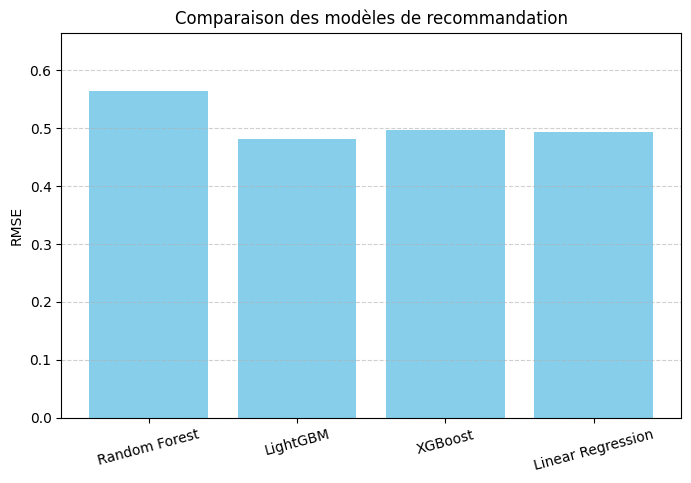


Modèle utilisé pour la recommandation : LightGBM

Top 5 recommandations pour l'utilisateur 42 :
                           name  predicted_rating
44        Parcours ninja indoor          4.704006
27     Visite guidée Montmartre          4.676063
2             Randonnée urbaine          4.666005
23   Concert de musique baroque          4.652331
17  Séance de méditation guidée          4.513645


In [1]:
# 1. Monter Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Importer les bibliothèques
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# 3. Charger les fichiers depuis ton dossier Drive
folder_path = "/content/drive/MyDrive/Ressources Algorithme de Recommandation/"

df_users = pd.read_csv(folder_path + "utilisateurs.csv")
df_activities = pd.read_csv(folder_path + "activites.csv")
df_interactions = pd.read_csv(folder_path + "interactions_utilisateur.csv")

# 4. Fusionner les données
df = df_interactions.merge(df_users, on="user_id", how="left")
df = df.merge(df_activities, on="activity_id", how="left")

# 5. Encodage des colonnes catégorielles
label_encoders = {}
for col in ["persona_category", "category", "location"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# 6. Préparer les features et target
features = ["user_id", "activity_id", "category", "vendor_id", "likes", "rating"]
target = "user_rating"

X = df[features]
y = df[target]

# 7. Split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Tester plusieurs modèles
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "LightGBM": LGBMRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0),
    "Linear Regression": LinearRegression()
}

results = {}
trained_models = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = rmse
    trained_models[name] = model
    print(f"{name} → RMSE : {rmse:.4f}")

# 9. Affichage du graphique comparatif
plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.ylabel("RMSE")
plt.title("Comparaison des modèles de recommandation")
plt.ylim(0, max(results.values()) + 0.1)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# 10. Recommandation personnalisée avec le meilleur modèle
best_model_name = min(results, key=results.get)
best_model = trained_models[best_model_name]
print(f"\nModèle utilisé pour la recommandation : {best_model_name}")

user_id = 42  # à changer selon l'utilisateur cible
user_data = df_users[df_users["user_id"] == user_id].iloc[0]
possible_activities = df_activities.copy()

possible_activities["user_id"] = user_id
possible_activities["persona_category"] = label_encoders["persona_category"].transform(
    [user_data["persona_category"]])[0]
possible_activities["category"] = label_encoders["category"].transform(possible_activities["category"])
possible_activities["location"] = label_encoders["location"].transform(possible_activities["location"])

X_new = possible_activities[features]
possible_activities["predicted_rating"] = best_model.predict(X_new)

recommendations = possible_activities.sort_values(by="predicted_rating", ascending=False)[["name", "predicted_rating"]].head(5)
print(f"\nTop 5 recommandations pour l'utilisateur {user_id} :")
print(recommendations)
